# 5.3 Lab: Cross-Validation and the Boostrap

In [1]:
# load modules
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy

from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 5.3.1 The validation Set Approach

In [2]:
# load data
df = pd.read_csv("./datasets/auto.csv",na_values="?").dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


We select a sample of 196 records as out training set.

In [3]:
# select training set
train = df.sample(n=df.shape[0]//2,random_state = 1)
print(train.shape)

(196, 9)


In [4]:
# filter out the records from the data to obtain the test set
test = df[~df.isin(train)].dropna(how='all')
test.shape

(196, 9)

We now use a linear regression to model the relationship between mpg and horsepower

In [5]:
# fit a linear regression on the training set
lr = sm.OLS.from_formula('mpg~horsepower',train)
result_lr = lr.fit()

In [6]:
# make predictions on the test set
pred_lr = result_lr.predict(test)

# compute the MSE on the training set
MSE_lt = np.mean(np.square(np.subtract(pred_lr,test['mpg'])))
print("MSE using linear regression = %f" % MSE_lt)

MSE using linear regression = 23.361903


We now fit polynomial models (degrees 2 and 3) and evaluate their performances.

In [7]:
# polynomial regression: deg = 2
lr_2 = sm.OLS.from_formula('mpg~horsepower+np.power(horsepower,2)',train)

# compute the MSE on the training set
MSE_2 = np.mean(np.square(np.subtract(lr_2.fit().predict(test),test['mpg'])))
print("MSE using polynomial regression of degree 2 = %f" % MSE_2)

MSE using polynomial regression of degree 2 = 20.252691


In [8]:
# polynomial regression: deg = 3
lr_3 = sm.OLS.from_formula('mpg~horsepower+np.power(horsepower,2)+np.power(horsepower,3)',train)

# compute the MSE on the training set
MSE_3 = np.mean(np.square(np.subtract(lr_3.fit().predict(test),test['mpg'])))
print("MSE using polynomial regression of degree 3 = %f" % MSE_3)

MSE using polynomial regression of degree 3 = 20.325609


Upon inspection of the MSE values, it seems that the polynomial regression of degree 2 leads the best results. We now repeat the test with a different seed.

In [9]:
# select training set
train = df.sample(n=df.shape[0]//2,random_state = 2)

# filter out the records from the data to obtain the test set
test = df[~df.isin(train)].dropna(how='all')

# linear regression:
lr = sm.OLS.from_formula('mpg~horsepower',train)

# compute the MSE on the training set
MSE = np.mean(np.square(np.subtract(lr.fit().predict(test),test['mpg'])))
print("MSE using linear regression = %f" % MSE)

# polynomial regression: deg = 2
lr_2 = sm.OLS.from_formula('mpg~horsepower+np.power(horsepower,2)',train)

# compute the MSE on the training set
MSE_2 = np.mean(np.square(np.subtract(lr_2.fit().predict(test),test['mpg'])))
print("MSE using polynomial regression of degree 2 = %f" % MSE_2)

# polynomial regression: deg = 3
lr_3 = sm.OLS.from_formula('mpg~horsepower+np.power(horsepower,2)+np.power(horsepower,3)',train)

# compute the MSE on the training set
MSE_3 = np.mean(np.square(np.subtract(lr_3.fit().predict(test),test['mpg'])))
print("MSE using polynomial regression of degree 3 = %f" % MSE_3)

MSE using linear regression = 25.108539
MSE using polynomial regression of degree 2 = 19.722533
MSE using polynomial regression of degree 3 = 19.921368


As expected, the results are not identical but the conclusion holds.

## 5.3.2 Leave-One-Out Cross-Validation

We now perform LOOCV using sklearn and perform a validation of a range of polynomial models using the horsepower feature to predict the mpg.

MSE =  [24.231513517929226, 19.248213124489677, 19.334984064029538, 19.424430310310466, 19.03321230864137, 18.97906897156583, 19.13378164524522, 19.224468106673758, 19.13410137337015]


Text(0,0.5,'LOOCV Error Rate')

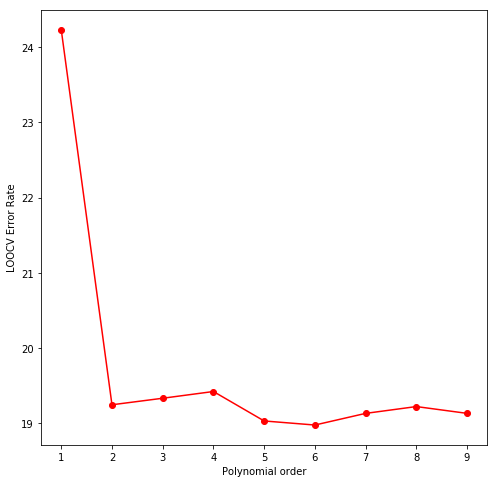

In [10]:
# Assign the data
X = df['horsepower']
X = X.values.reshape(-1,1)
y = df['mpg']

loo = LeaveOneOut()
loo.get_n_splits(df)
MSEs = []

poly_orders = np.arange(1,10)

for idx, order in enumerate(poly_orders):
    # create model
    poly = PolynomialFeatures(degree = order, interaction_only=False,include_bias=False)

    
    # create the regression model
    model = LinearRegression()
    model.fit(poly.fit_transform(X),y)
    
    # compute MSE
    MSE = -np.mean(model_selection.cross_val_score(model,
                                                   poly.fit_transform(X), y,
                                                   cv=loo,
                                                   scoring='neg_mean_squared_error'))
    MSEs.append(MSE)

print("MSE = ", MSEs)

# plot the results
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(poly_orders,MSEs,marker = 'o',color='r')
ax.set_xlabel('Polynomial order')
ax.set_ylabel("LOOCV Error Rate")

## 5.3.3 k-Fold Cross-Validation

MSE =  [27.43993365233988, 21.235840055802235, 21.336606183228163, 21.353886982296252, 20.90564071824954, 20.780704829707744, 21.0148647456957, 21.078234790939696, 21.037202233585443]


Text(0,0.5,'LOOCV Error Rate')

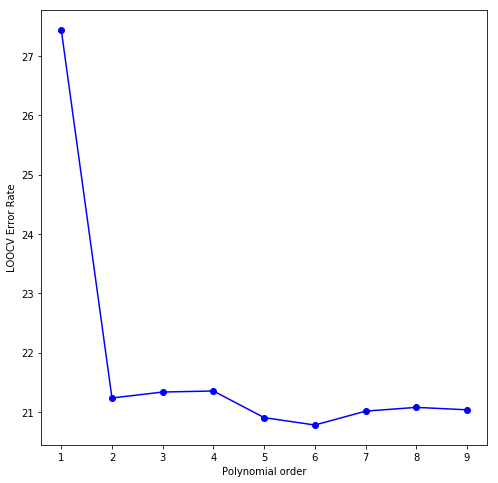

In [11]:
# Prepare k-fold cross-val: 10 folds
folds = 10
MSEs_k = []

poly_orders = np.arange(1,10)


for idx, order in enumerate(poly_orders):
    # create model
    poly = PolynomialFeatures(degree = order, interaction_only=False,include_bias=False)
    
    # k-fold
    kf_10 = KFold(n_splits=folds,random_state=df)
    
    # compute MSE
    MSE_k = -np.mean(model_selection.cross_val_score(model,
                                                   poly.fit_transform(X), y,
                                                   cv=kf_10,
                                                   scoring='neg_mean_squared_error')).mean()
    MSEs_k.append(MSE_k)

print("MSE = ", MSEs_k)

# plot the results
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(poly_orders,MSEs_k,marker = 'o',color='b')
ax.set_xlabel('Polynomial order')
ax.set_ylabel("LOOCV Error Rate")

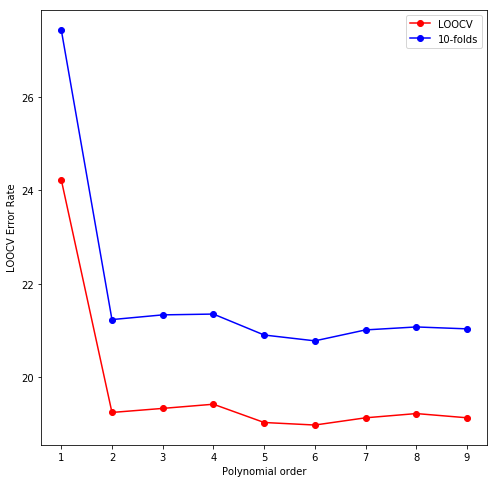

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(poly_orders,MSEs,marker = 'o',color='r',label='LOOCV')
ax.plot(poly_orders,MSEs_k,marker = 'o',color='b',label='10-folds')
ax.set_xlabel('Polynomial order')
ax.set_ylabel("LOOCV Error Rate")
ax.legend();

## 5.3.4 Bootstrap

In [13]:
# read data
df = pd.read_csv('./datasets/Portfolio.csv')
df.head()

,Unnamed: 0,X,Y
0,1,-0.895251,-0.234924
1,2,-1.562454,-0.885176
2,3,-0.417090,0.271888
3,4,1.044356,-0.734198
4,5,-0.315568,0.841983


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
Unnamed: 0    100 non-null int64
X             100 non-null float64
Y             100 non-null float64
dtypes: float64(2), int64(1)
memory usage: 2.4 KB


**Estimating the Accuracy of a Statistic of Interest**:

In [15]:
# compute the alpha statistic
def alpha_stat(df,indices):
    """
    Return the optimal portfolio allocation to minimize the risk
    """
    X = df.X[indices].values
    Y = df.Y[indices].values
    
    return (np.var(Y)-np.cov(X,Y)[0][1])/(np.var(X)+np.var(Y)-2*np.cov(X,Y)[0][1])

In [16]:
# optimal alpha:
print("alpha statistic: %f" % alpha_stat(df,df.index))

alpha statistic: 0.576651


We now create a function to draw bootstrap replicates from the original dataset.

In [81]:
def draw_boot(df, agg, n_boot=100, n_size=100):
    """
    Draw n_boot bootstrap from the dataset df. The size of the bootstrat is defined by n_size and the agg function is
    used to aggregate the bootstrap into a single statistic.
    """
    boot_samples = []
    for boot in range(n_boot):
        # select data with replacement
        indices = np.random.choice(df.index, n_size, replace=True)
        boot_samples.append(agg(df, indices))
    
    # compute the standard error of the estimate
    se_estimate = scipy.std(boot_samples,axis=0)
    print('\nBootstrapped Std. Error(s) =', se_estimate)

In [82]:
np.random.seed(0)
draw_boot(df, alpha_stat, 1000, 100)


Bootstrapped Std. Error(s) = 0.08980409161302538


Using bootstrap, we estimate $\hat \alpha$ as 0.581 and a standard error of 0.090. The theoretical value of $\alpha$ is 0.577.

** Estimating the Accuracy of a Linear Regression Model***

In [83]:
# load auto dataset, note before we have found that horsepower column contains ? values we convert to nans
auto = pd.read_csv('datasets/Auto.csv', na_values='?')
auto = auto.dropna()
auto.reset_index(drop=True,inplace=True)

In [84]:
# boostrap regression
def boot(data, indices):
    """
    Takes in teh Auto data set as well as a set of indices for the observations, and returns teh intercept and slope
    estimates for the linear regression model.
    """
    X = data.horsepower[indices].values
    X = sm.add_constant(X)
    y = data.mpg[indices].values
    lm_fit = sm.OLS(y, X).fit()
    return lm_fit.params

In [85]:
# test
boot(auto, auto.index)

array([39.93586102, -0.15784473])

We now combine our boot function with the draw_boot one.

In [86]:
np.random.seed(0)
draw_boot(auto,boot,n_boot=1000,n_size=auto.shape[0])


Bootstrapped Std. Error(s) = [0.85288648 0.00726551]


This indicates that the bootstrap estimate for $SE(\hat\beta_0)$ is 0.85, and that the bootstrap estimate for $SE(\hat\beta_1)$ is 0.0076. As discussed in Section 3.1.2, standard formulas can be used to compute the standard errors for the regression coefficients in a linear model. These can be obtained using the summary() function.

In [89]:
sm.OLS.from_formula('mpg~horsepower', auto).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           7.03e-81
Time:                        17:30:15   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The standard error estimates for $\hat\beta_0$ and $\hat\beta_1$ obtained using the formulas from Section 3.1.2 are 0.717 for the intercept and 0.0064 for the slope. Interestingly, these are somewhat different from the estimates obtained using the bootstrap. Does this indicate a problem with the bootstrap? In fact, it suggests the opposite. Recall that the standard formulas given in Equation 3.8 on page 66 rely on certain assumptions. For example, they depend on the unknown parameter $\sigma^2$, the noise variance. We then estimate $\sigma^2$ using the RSS. Now although the formula for the standard errors do not rely on the linear model being correct, the estimate for $\sigma^2$ does. We see in Figure 3.8 on page 91 that there is a non-linear relationship in the data, and so the residuals from a linear fit will be inflated, and so will $\sigma^2$. Secondly, the standard formulas assume (somewhat unrealistically) that the $x_i$ are fixed, and all the variability comes from the variation in the errors $\epsilon_i$. The bootstrap approach does not rely on any of these assumptions, and so it is likely giving a more accurate estimate of the standard errors of $\hat\beta_0$ and $\hat\beta_1$ than is the summary() function.

Below we compute the bootstrap standard error estimates and the standard linear regression estimates that result from fitting the quadratic model to the data. Since this model provides a good fit to the data (Figure 3.8), there is now a better correspondence between the bootstrap estimates and the standard estimates of $SE(\hat\beta_0)$, $SE(\hat\beta_1)$ and $SE(\hat\beta_2)$.

In [88]:
sm.OLS.from_formula('mpg~horsepower+np.power(horsepower,2)', auto).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           5.40e-99
Time:                        17:29:44   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  56.9001      1.800     31.604      0.000      53.360      60.440
horsepower                 -0.4662      0.031    -14.978      0.000      -0.527      -0.405
np.power(horsepower, 2)     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""